In [1]:
import numpy as np
import math
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from qiskit import transpile, QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import UnitaryGate
from qiskit.visualization import plot_histogram
from qiskit_aer import Aer, AerSimulator

## RUN RANDOM MATRIX INPUT

In [2]:
def nXOR(qc, qubits, output):
    for q in qubits:
        qc.cx(q, output)
    qc.barrier()

def XOR1(qc, a, output):
    qc.cx(a, output)
    qc.barrier()

def get_phase_gate(n):
    size = 2**n
    i = -np.eye(size)
    i[0][0] = 1
    phase_gate = UnitaryGate(i)
    return phase_gate

In [3]:
def diffuser(n):
    qc = QuantumCircuit(n)
    for q in range(n):
        qc.h(q)
    qc.append(get_phase_gate(n), range(n))
    for q in range(n):
        qc.h(q)
    U_s = qc.to_gate()
    U_s.name = "U_s"
    return U_s

In [4]:
def generate_clause_list(A, n):
    clause_list = []
    
    for i in range(n):
        l = []
        for j in range(n):
            if A.item((i, j)) == 1:
                l.append(j)
        clause_list.append(l)
    
    return clause_list

In [5]:
def lights_out_oracle(n, qc, var_qubits, p_qubits, eq_qubits, sol_qubit, c_bits, clause_list):
    
    qc.barrier()
    i = 0
    for clause in clause_list:
        clause = [var_qubits[c] for c in clause]
        nXOR(qc, clause, eq_qubits[i])
        i += 1
    
    for i in range(n):
        XOR1(qc, p_qubits[i], eq_qubits[i])
    qc.x(eq_qubits)
    
    qc.mcx(eq_qubits, sol_qubit)
    
    i = 0
    for clause in clause_list:
        clause = [var_qubits[c] for c in clause]
        nXOR(qc, clause, eq_qubits[i])
        i += 1
    
    for i in range(n):
        XOR1(qc, p_qubits[i], eq_qubits[i])
    qc.x(eq_qubits)
    
    qc.barrier()
    
    qc.append(diffuser(n), range(n))
    

In [6]:
def lights_out_solver(A, p, n, t):
    var_qubits = QuantumRegister(n, name='click')
    p_qubits = QuantumRegister(n, name='initial')
    eq_qubits = QuantumRegister(n, name='output')  
    sol_qubit = QuantumRegister(1, name='solution')
    c_bits = ClassicalRegister(n, name='classical')
    
    clause_list = generate_clause_list(A, n)
    qc = QuantumCircuit(var_qubits, p_qubits, eq_qubits, sol_qubit, c_bits)
    
    # INITIALIZATION
    # - STATE on SOLUTION QUBIT
    qc.x(sol_qubit)
    qc.h(sol_qubit)
    
    # Initial state to solve
    for i in range(n):
        if p[i] == 1:
            qc.x(p_qubits[i])
    
    
    # SUPERPOSITION OF BITSTRING with UNIFORM DISTRIBUTION
    qc.h(var_qubits)
    
    for i in range(t):
        lights_out_oracle(n, qc, var_qubits, p_qubits, eq_qubits, sol_qubit, c_bits, clause_list)
    
    for i in range(n):
        qc.measure(var_qubits[i], c_bits[i])
    
    return qc

## 5 Node graph with 4 solutions

In [7]:
A = np.matrix([[1., 0., 1., 0., 0.],
       [0., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [0., 1., 1., 1., 1.],
       [0., 1., 1., 1., 1.]])
print(A)

[[1. 0. 1. 0. 0.]
 [0. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [0. 1. 1. 1. 1.]
 [0. 1. 1. 1. 1.]]


In [8]:
G = nx.Graph(A - np.eye(A.shape[0]))

In [9]:
print("RANK : ", np.linalg.matrix_rank(A))

RANK :  3


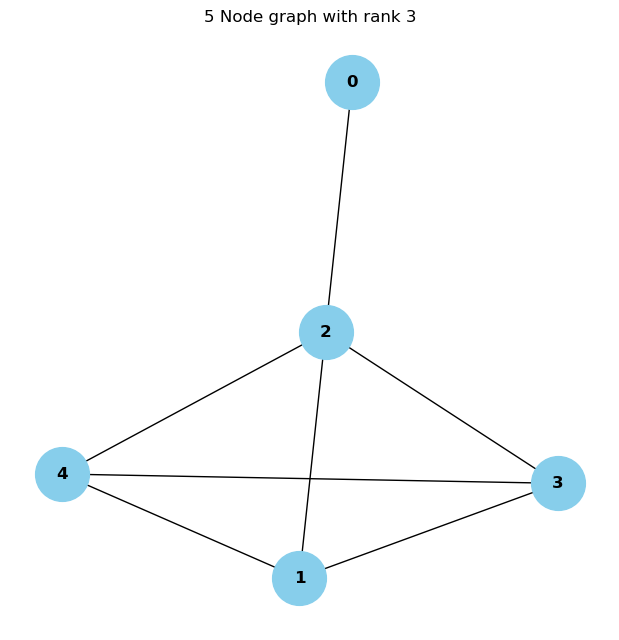

In [10]:
plt.figure(figsize=(6, 6))
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, font_size=12, font_weight='bold')
plt.title("5 Node graph with rank 3")
plt.show()

In [11]:
p = [1, 1, 0, 1, 1]
qc = lights_out_solver(A, p, len(A), 2)

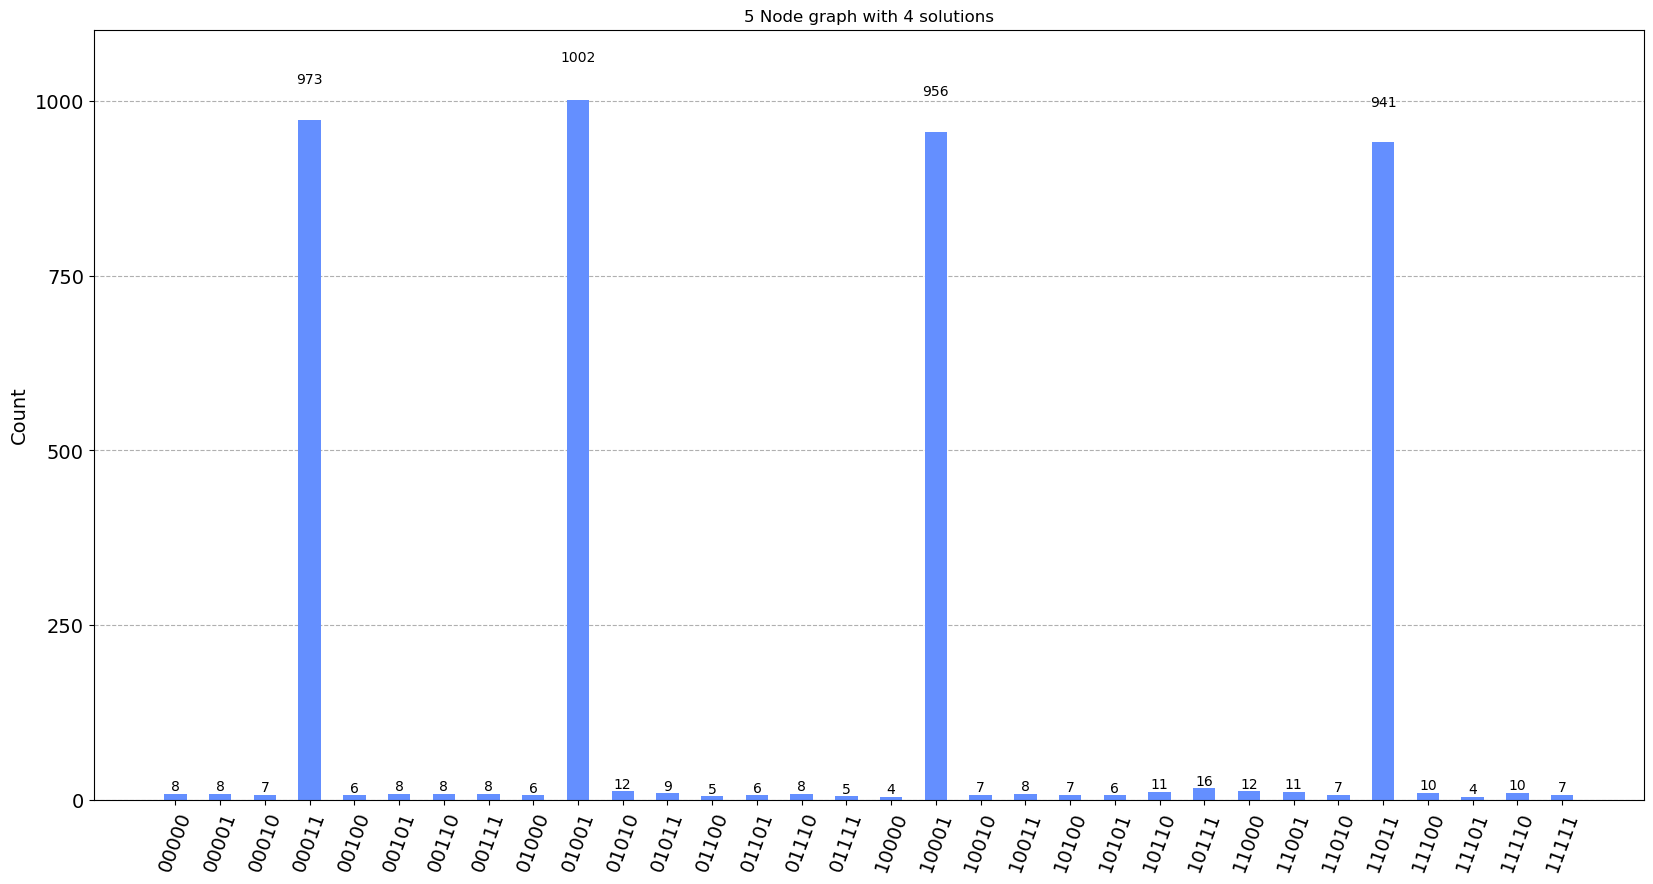

In [12]:
qasm_simulator = Aer.get_backend('qasm_simulator')
transpiled_qc = transpile(qc, qasm_simulator)
result = qasm_simulator.run(transpiled_qc, shots=4096).result()
plot_histogram(result.get_counts(), figsize=(20, 10), title="5 Node graph with 4 solutions")

## 5 Node graph with one solution

In [13]:
A = np.matrix([[1., 1., 1., 0., 1.],
               [1., 1., 0., 0., 0.],
               [1., 0., 1., 0., 0.],
               [0., 0., 0., 1., 1.],
               [1., 0., 0., 1., 1.]])


In [14]:
G = nx.Graph(A - np.eye(A.shape[0]))

In [15]:
print("RANK : ", np.linalg.matrix_rank(A))

RANK :  5


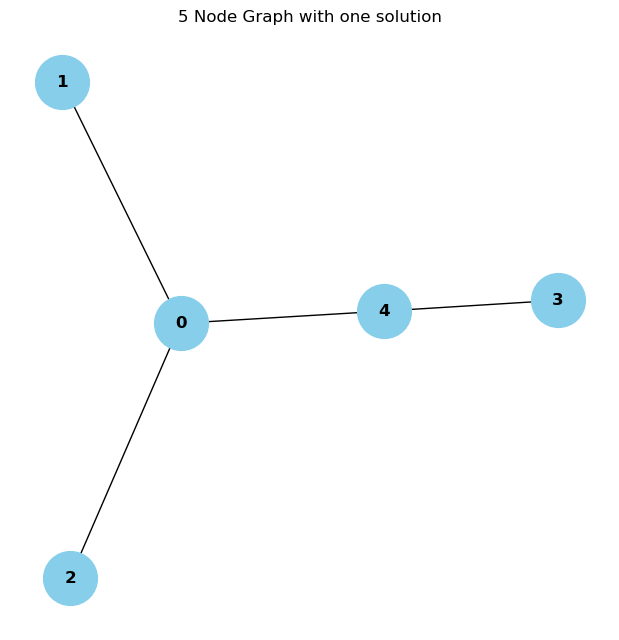

In [16]:
plt.figure(figsize=(6, 6))
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, font_size=12, font_weight='bold')
plt.title("5 Node Graph with one solution")
plt.show()

In [17]:
p = [1, 0, 1, 0, 1]
qc = lights_out_solver(A, p, len(A), 3)

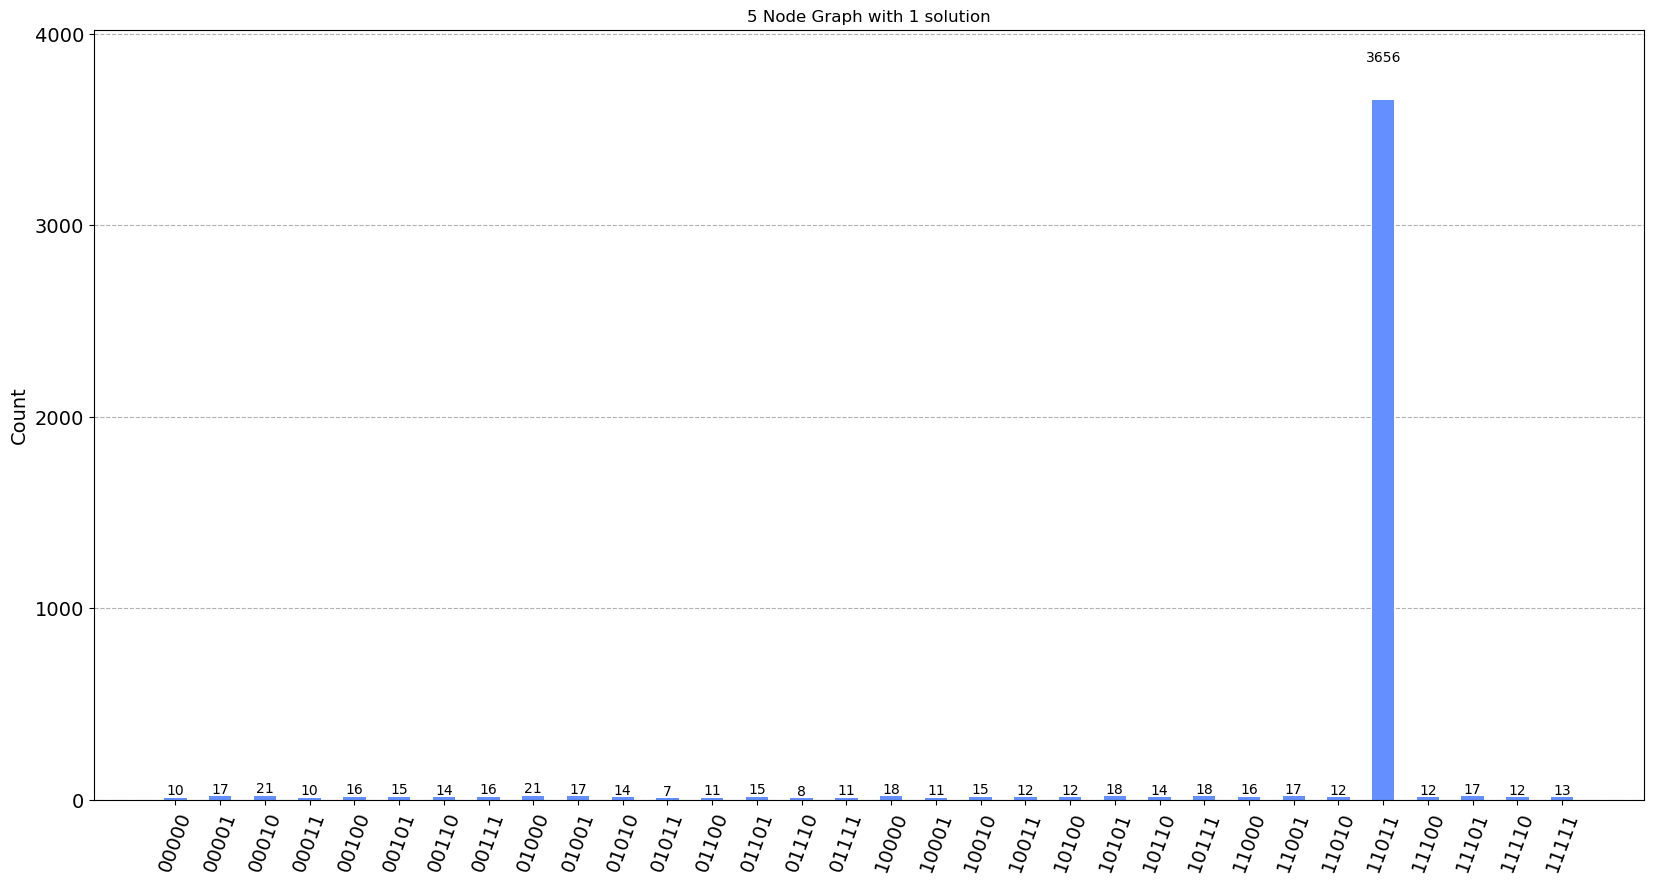

In [18]:
qasm_simulator = Aer.get_backend('qasm_simulator')
transpiled_qc = transpile(qc, qasm_simulator)
result = qasm_simulator.run(transpiled_qc, shots=4096).result()
plot_histogram(result.get_counts(), figsize=(20, 10), title="5 Node Graph with 1 solution")